# ☢ 인공지능 폐렴 진단기 ☢

## ▶ 폐렴 진단 기술 및 X-RAY 특성

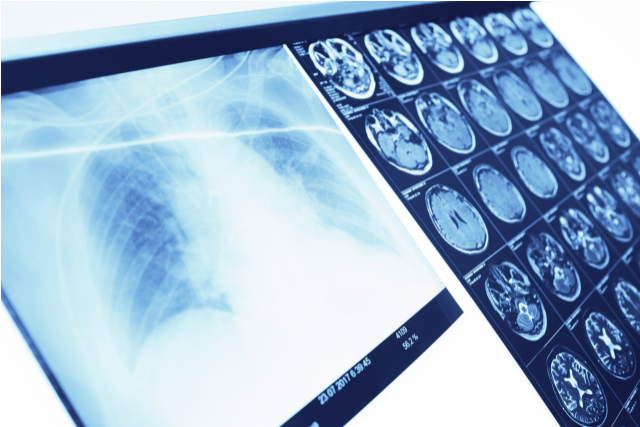

딥러닝 기술이 산업적으로 명확한 용도를 입증한 도메인 중 하나로 의료 분야를 들 수 있다.   
의료 영상을 분석하는 일은 전문적인 훈련을 받은 의료 인력만 가능한 일이지만,   
발달된 딥러닝 기술은 숙련자 수준 이상의 정확도를 바탕으로 영상분석 인력의    
**개인적 편차**, **주관적 판단**, **피로에 의한 오진** 등의 부정확성을 극복할 수 있는 좋은 대안으로 인정받고 있다.


- 의료 영상 이미지는 개인 정보 보호 등으로 데이터를 구하는 것이 쉽지 않음.


- 라벨링 작업 자체가 전문적 지식을 요하므로 데이터셋 구축 비용이 비쌈.


- 희귀질병을 다루는 경우 데이터를 입수하는 것 자체가 힘듬.


- 음성/양성 데이터 간 imbalance가 심하여 학습에 주의가 필요함.


- 이미지만으로 진단이 쉽지 않아 다른 데이터와 결합해서 해석이 요구.


**이번에 다룰 이미지는 X-RAY 이미지로 간단히 알아보자**

![해부학 용어](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e5/Planes_of_Body.jpg/440px-Planes_of_Body.jpg)

위 이미지에서 의료 영상 촬영은 인체를 세 방향의 단면으로 나눈다.


- **Sagittal plane** : 시상면. 사람을 왼쪽과 오른쪽을 나누는 면

- **Coronal plane** : 관상면. 인체를 앞뒤로 나누는 면

- **Transverse plane** : 횡단면(수평면). 인체를 상하로 나누는 면

예시로 아래의 사진을 보자.


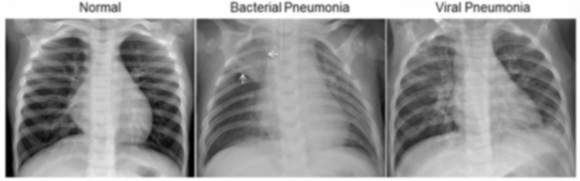

위 이미지는 흉부 부분이며 폐와 갈비뼈가 보이는 것을 확인할 수 있다.   


3가지 Sagittal plane, Coronal plane, Transverse plane 중 어느 방향의 이미지에 포함될까?


- 관상면(Coronal plane)에 해당된다.

### X-RAY 특성


X-RAY는 전자기파가 몸을 통과하여 이를 이미지화 시킨 것이다. 통과하고 남은 전자기파의 결과여서 색상이 흑백 명암으로 나온다.


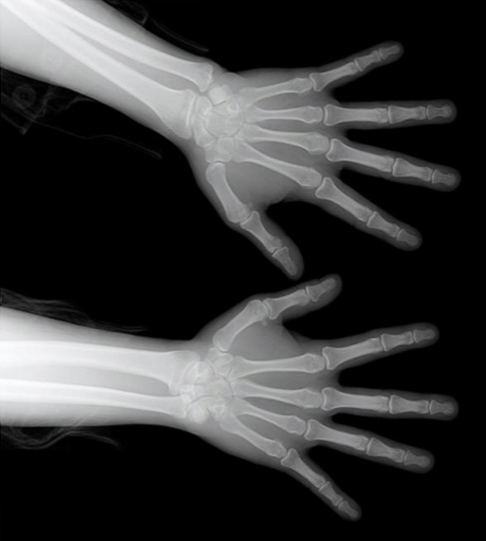

- 뼈: 하얀색
- 근육 및 지방: 연한 회색
- 공기: 검은색

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/10.png)

흉부 쪽 영상이다.

- 갈비뼈: 하얀색
- 폐: 검은색
- 어깨 쪽의 지방 및 근육: 연한 회색


폐는 공기가 많이 차 있어서 검은색으로 나온다.

## 😀 프로젝트: 폐렴 진단기 성능개선 😀

1. 실험환경 Set-up


2. 데이터 준비하기


3. 데이터 시각화


4. CNN 모델링


5. 데이터 Imbalance 처리


6. 모델 훈련


7. 결과 확인 시각화


8. 성능 개선


9. 회고 

### 1. 실험 환경 Set-up

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = '/Users/beatelfeed/aiffel/Pneumonia diagnosis/chest_xray/data'
TRAIN_PATH = ROOT_PATH + '/train/*/*'
VAL_PATH = ROOT_PATH + '/val/*/*'
TEST_PATH = ROOT_PATH + '/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경
BATCH_SIZE = 16 
EPOCHS = 25

print(TRAIN_PATH)

/Users/beatelfeed/aiffel/Pneumonia diagnosis/chest_xray/data/train/*/*


### 2. 데이터 준비하기

In [ ]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있다.

- val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 사용해야된다.

- train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하자.

In [ ]:
#train 데이터와 validation 데이터를 모두 filenames에 담음.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

#train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할.
train_size = math.floor(len(filenames)*0.8)
random.seed(16)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- train 안에는 4185개, val 안에는 1047개가 있다.

- train 데이터 안에 정상 이미지와 폐렴 이미지 수를 확인해보자.

In [ ]:
# 정상 이미지와 폐렴 이미지를 구분
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')
print()

# NORMAL이 있는지 확인하면 정상 이미지 count
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# NORMAL이 있는지 확인하면 폐렴 이미지 count
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal image path
/Users/beatelfeed/aiffel/Pneumonia diagnosis/chest_xray/data/train/PNEUMONIA/person1199_bacteria_3149.jpeg
Pneumonia image path
/Users/beatelfeed/aiffel/Pneumonia diagnosis/chest_xray/data/train/NORMAL/IM-0170-0001.jpeg

Normal images count in training set: 1073
Pneumonia images count in training set: 3112


- **Normal images count in training set**: 1096

- **Pneumonia images count in training set**: 3092

- 폐렴 이미지가 더 많이 있는 것을 확인

폐렴 이미지 수가 3배 더 많이 있다. 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 한다.

데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정이다.
 
test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없다.

- tf.data 인스턴스를 만들어 tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 하자.



In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")
print()

# 이미지에는 라벨 데이터가 없음. 'NORMAL', 'PNEUMONIA' 이용해서 라벨 데이터를 만들어 주는 함수

def get_label(file_path): # 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)


# 이미지 데이터는 사이즈가 제각각일 가능성이 높다.
# 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄이자.
# 이미지를 알맞은 형식 바꾸기.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label


# train 데이터 셋과 validation 데이터 셋
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) # num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Training images count: 4185
Validating images count: 1047

Image shape:  (180, 180, 3)
Label:  True


- Image shape:  (180, 180, 3)


- Label:  False

- 사이즈가 변환이 되었다.

- train과 validation 데이터셋을 만든 것 처럼 test 데이터셋도 만들자.

In [ ]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [ ]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat() #epoch 횟수만큼 repeat
    ds = ds.batch(BATCH_SIZE) 
    ds = ds.prefetch(buffer_size=AUTOTUNE) #학습 데이터 나눠서 읽어와 GPU에서 학습하는 동안 다음 데이터를 CPU에서 준비
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 3. 데이터 시각화

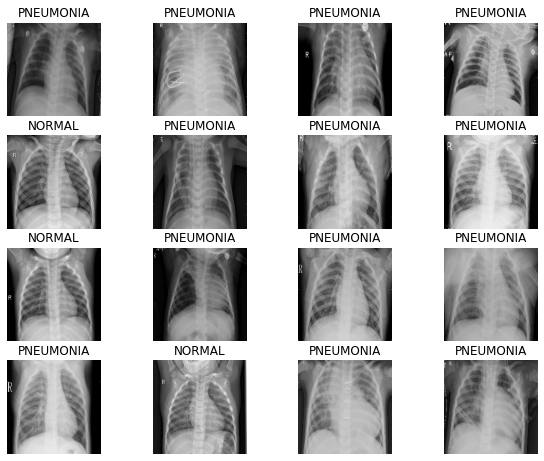

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 4. CNN 모델 구성

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

위 모델에서는 조금 특이하게 Batch Normalization과 Dropout이라는 두가지 regularization 기법이 동시에 사용되고 있다. 

일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 한다. 대표적으로 아래와 같은 논문의 사례를 들 수 있다.


- [Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fopenaccess.thecvf.com%2Fcontent_CVPR_2019%2Fpapers%2FLi_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf&clen=1272425&chunk=true)


위 논문에서는 variance shift를 억제하는 Batch Normalization과 이를 유발시키는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 한다.


실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 사례도 있다. 동시에 사용하는 것이 성능향상에 도움을 주는 경우가 실제로 있다. 


아래 논문 참조.


- [Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Farxiv.org%2Fpdf%2F1905.05928.pdf&clen=856720&chunk=true)

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.001),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.001),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 5. 데이터 Imbalance 처리


'Normal'과 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었다. 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습 할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다.


이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용된다. Weight balancing 은 training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다. Keras는 `model.fit()`을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있다. 


<상세한 내용은 아래 링크를 참고하자.>


- [딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)

In [ ]:
# weight_for_0은 'Normal' 이미지에 사용할 weight를, 
# weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅.
# weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [ ]:
# pip install "keras==2.6.0"

In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

### 6. 모델 훈련하기


- 이미지 훈련은 GPU를 사용할 것이라 먼저 GPU를 선택한다. ---- <아주 좋은 것>   


- 모델은 위에서 만들었던 모델 함수 `build_model()` 로 선언   


- 이미지의 라벨이 두 개뿐이라 "binary_cross entropy"loss를 사용한다.   


- optimizer로 'adam'을 사용한다.


- 결과 측정은 metrics로 'accuracy', 'precision', recall'을 사용한다.

In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# model fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 149s 542ms/step - loss: 0.3348 - accuracy: 0.8511 - precision: 0.9627 - recall: 0.8319 - val_loss: 0.6840 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/25
209/261 [=======================>......] - ETA: 25s - loss: 0.2222 - accuracy: 0.9133 - precision: 0.9750 - recall: 0.9070

### 7. 결과 확인 시각화

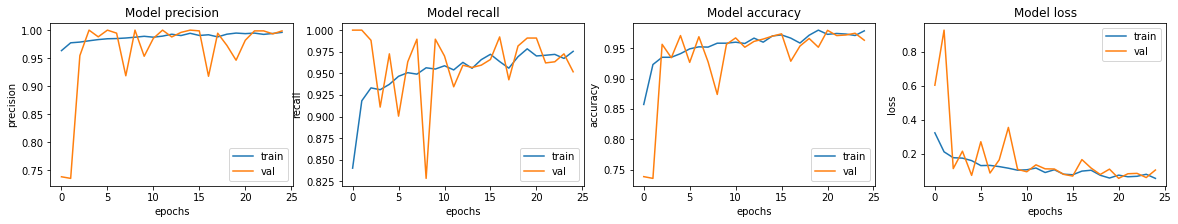

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 152ms/step - loss: 1.0209 - accuracy: 0.8029 - precision: 0.7697 - recall: 0.9769
Loss: 1.0208580493927002,
Accuracy: 0.8028846383094788,
Precision: 0.7696969509124756,
Recall: 0.9769230484962463


### 8. 성능 개선




In [ ]:
def augment1(image,label):
    
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label
    
def augment2(image,label):
    
    image = tf.image.random_flip_up_down(image)  # 랜덤하게 상하를 반전합니다.
    return image,label
    
def prepare_for_training(ds, shuffle_buffer_size=1000):
        
    ds = ds.map(augment1,num_parallel_calls=2)
    ds = ds.map(augment2,num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat() #epoch 횟수만큼 repeat
    ds = ds.batch(BATCH_SIZE) 
    ds = ds.prefetch(buffer_size=AUTOTUNE) #학습 데이터 나눠서 읽어와 GPU에서 학습하는 동안 다음 데이터를 CPU에서 준비
    return ds

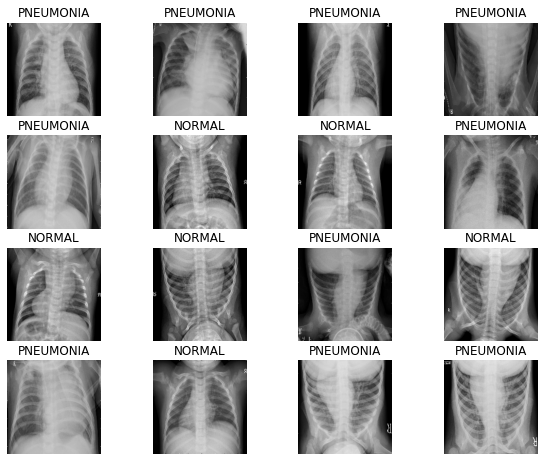

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
    
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    
train_ds = prepare_for_training(train_ds)

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

def modify_params(BATCH_SIZE = 16,epoches = 25,optimizer = 'rmsprop',rugularizer = 0,class_weight = class_weight,augment = True):
    
    # 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다.
    def get_label(file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

    # 이미지를 알맞은 형식으로 바꾼다.
    def decode_img(img):
        img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
        img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
        img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
        return img

    # 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어온다.
    def process_path(file_path):
        label = get_label(file_path) # 라벨 검출
        img = tf.io.read_file(file_path) # 이미지 읽기
        img = decode_img(img) # 이미지를 알맞은 형식으로 수정
        return img, label
    
    def augment1(image,label):
        image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전.
        return image,label
    
    def augment2(image,label):
        image = tf.image.random_flip_up_down(image)  # 랜덤하게 상하를 반전.
        return image,label
    
    def prepare_for_training(ds, shuffle_buffer_size=1000):
        
        ds = ds.map(augment1,num_parallel_calls=2)
        ds = ds.map(augment2,num_parallel_calls=2)
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        ds = ds.repeat() #epoch 횟수만큼 repeat
        ds = ds.batch(BATCH_SIZE) 
        ds = ds.prefetch(buffer_size=AUTOTUNE) #학습 데이터 나눠서 읽어와 GPU에서 학습하는 동안 다음 데이터를 CPU에서 준비
        return ds
    
    train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
    val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
    
    train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    
    train_ds = prepare_for_training(train_ds)
    val_ds = prepare_for_training(val_ds)
    
    test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
    TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
    test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE)
    
    
    # Model
    def conv_block(filters):
        block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
        return block
    
    def dense_block(units, dropout_rate):
        block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
        return block
    
    def build_model():
        model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
        return model
    
    with tf.device('/GPU:0'):
        model = build_model()
        
        earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=4,         # 4회 Epoch동안 개선되지 않는다면 종료
                             )

        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
                    ]
    
        model.compile(
            optimizer= optimizer,
            loss='binary_crossentropy',
            metrics=METRICS
                    )
    
        history = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=val_ds,
            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
            class_weight=class_weight,
            callbacks = earlystopping
                            )
    
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
    
    eval_result = {'loss' : loss, 'accuracy' : accuracy, 'precision' : precision, 'recall' : recall}
    
    return history, eval_result

In [ ]:
def plot(history):

    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

#### ▶ 모델1: 


- BATCH_SIZE = 16

- epoches = 25

- optimizer = 'adam'

- rugularizer = 0

- class_weight = class_weight

- augment = True

In [ ]:
model1 = modify_params()

Epoch 1/25
261/261 [==============================] - 171s 630ms/step - loss: 0.3416 - accuracy: 0.8403 - precision: 0.9607 - recall: 0.8188 - val_loss: 0.5787 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 158s 607ms/step - loss: 0.2311 - accuracy: 0.9071 - precision: 0.9742 - recall: 0.8989 - val_loss: 1.1070 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 159s 609ms/step - loss: 0.2055 - accuracy: 0.9133 - precision: 0.9738 - recall: 0.9079 - val_loss: 0.2527 - val_accuracy: 0.9106 - val_precision: 0.9970 - val_recall: 0.8809
Epoch 4/25
261/261 [==============================] - 156s 599ms/step - loss: 0.1899 - accuracy: 0.9260 - precision: 0.9791 - recall: 0.9201 - val_loss: 0.0934 - val_accuracy: 0.9635 - val_precision: 0.9853 - val_recall: 0.9647
Epoch 5/25
261/261 [==============================] - 181s 692ms/step - loss: 0.1569 - a

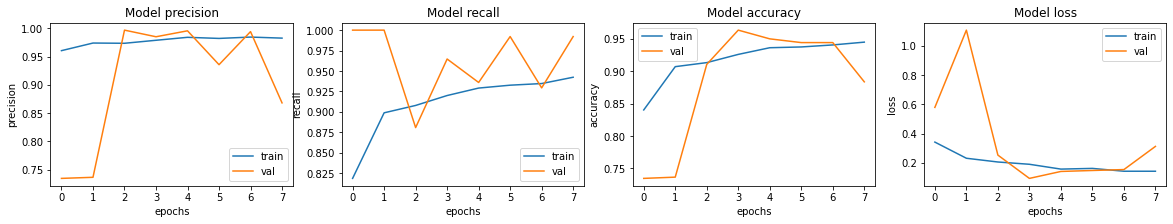

In [ ]:
plot(model1[0])

#### ▶ 모델2: 


- BATCH_SIZE = 32

- 나머지 동일

In [ ]:
model2 = modify_params(BATCH_SIZE = 32)

Epoch 1/25
130/130 [==============================] - 160s 1s/step - loss: 0.2666 - accuracy: 0.8882 - precision: 0.9747 - recall: 0.8724 - val_loss: 0.6253 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 153s 1s/step - loss: 0.1916 - accuracy: 0.9245 - precision: 0.9777 - recall: 0.9195 - val_loss: 0.8690 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 145s 1s/step - loss: 0.1702 - accuracy: 0.9334 - precision: 0.9766 - recall: 0.9328 - val_loss: 0.8432 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 141s 1s/step - loss: 0.1466 - accuracy: 0.9430 - precision: 0.9805 - recall: 0.9423 - val_loss: 1.0282 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/25
20/20 [==============================] - 8s 371ms/step - loss: 2.3284 - accuracy: 0.6250 

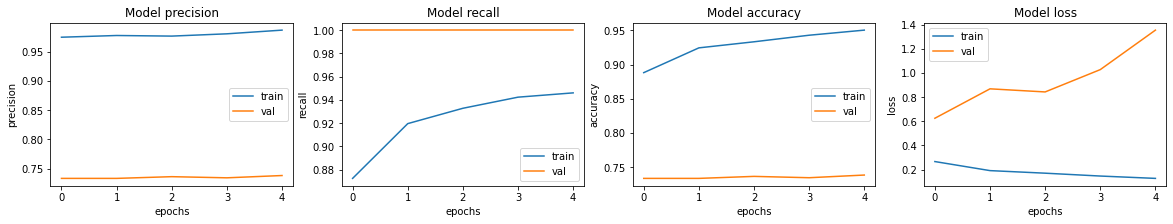

In [ ]:
plot(model2[0])

#### ▶ 모델 3: 


- BATCH_SIZE = 8

- 나머지 동일

In [ ]:
model3 = modify_params(BATCH_SIZE = 8)

Epoch 1/25
523/523 [==============================] - 189s 345ms/step - loss: 0.3653 - accuracy: 0.8246 - precision: 0.9528 - recall: 0.8040 - val_loss: 1.8483 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
523/523 [==============================] - 180s 344ms/step - loss: 0.2686 - accuracy: 0.8836 - precision: 0.9669 - recall: 0.8734 - val_loss: 0.1693 - val_accuracy: 0.9519 - val_precision: 0.9877 - val_recall: 0.9464
Epoch 3/25
523/523 [==============================] - 175s 334ms/step - loss: 0.2364 - accuracy: 0.9027 - precision: 0.9757 - recall: 0.8914 - val_loss: 0.1343 - val_accuracy: 0.9558 - val_precision: 0.9650 - val_recall: 0.9751
Epoch 4/25
523/523 [==============================] - 171s 326ms/step - loss: 0.2151 - accuracy: 0.9166 - precision: 0.9775 - recall: 0.9088 - val_loss: 0.4364 - val_accuracy: 0.8356 - val_precision: 1.0000 - val_recall: 0.7765
Epoch 5/25
523/523 [==============================] - 175s 335ms/step - loss: 0.2255 - a

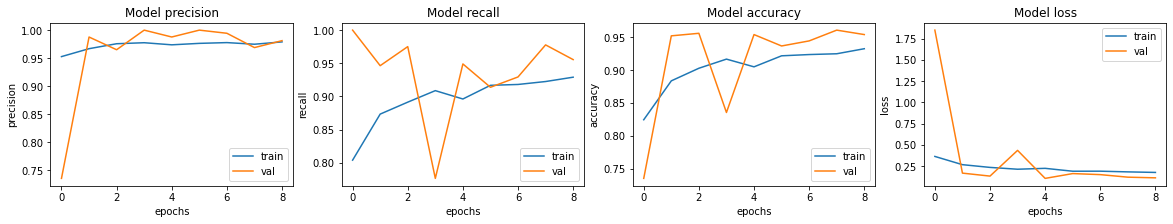

In [ ]:
plot(model3[0])

#### ▶ 모델 4:


- BATCH_SIZE = 8

- BN 만 진행

- ~~Dropout 제거~~

In [ ]:
model4 = modify_params(BATCH_SIZE = 8)

Epoch 1/25
523/523 [==============================] - 157s 287ms/step - loss: 0.3791 - accuracy: 0.8253 - precision: 0.9535 - recall: 0.8043 - val_loss: 0.7400 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
523/523 [==============================] - 161s 307ms/step - loss: 0.2883 - accuracy: 0.8755 - precision: 0.9669 - recall: 0.8622 - val_loss: 1.5535 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
523/523 [==============================] - 162s 310ms/step - loss: 0.2882 - accuracy: 0.8733 - precision: 0.9664 - recall: 0.8595 - val_loss: 0.1887 - val_accuracy: 0.9423 - val_precision: 0.9446 - val_recall: 0.9791
Epoch 4/25
523/523 [==============================] - 163s 311ms/step - loss: 0.2842 - accuracy: 0.8783 - precision: 0.9677 - recall: 0.8654 - val_loss: 0.2116 - val_accuracy: 0.8990 - val_precision: 0.8834 - val_recall: 0.9934
Epoch 5/25
523/523 [==============================] - 168s 322ms/step - loss: 0.2495 - a

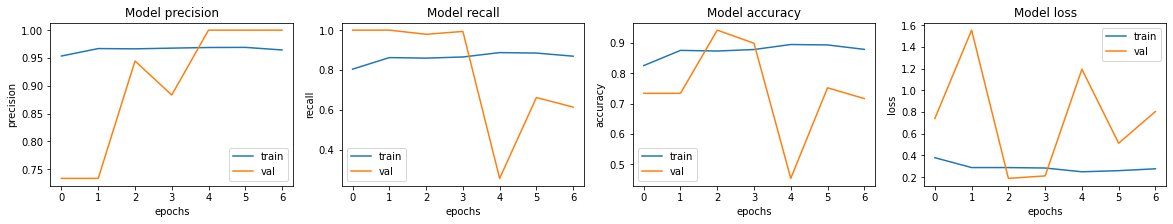

In [ ]:
plot(model4[0])

#### ▶ 모델 5:


- BATCH_SIZE = 16

- Dropout 만 진행

- ~~BN 제거~~

In [ ]:
model5 = modify_params()

Epoch 1/25
261/261 [==============================] - 170s 612ms/step - loss: 0.3341 - accuracy: 0.8503 - precision: 0.9596 - recall: 0.8338 - val_loss: 0.6176 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 157s 603ms/step - loss: 0.2121 - accuracy: 0.9162 - precision: 0.9732 - recall: 0.9124 - val_loss: 1.8016 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 159s 610ms/step - loss: 0.1980 - accuracy: 0.9241 - precision: 0.9781 - recall: 0.9186 - val_loss: 0.1168 - val_accuracy: 0.9587 - val_precision: 0.9604 - val_recall: 0.9843
Epoch 4/25
261/261 [==============================] - 161s 616ms/step - loss: 0.1655 - accuracy: 0.9361 - precision: 0.9781 - recall: 0.9350 - val_loss: 1.0531 - val_accuracy: 0.6683 - val_precision: 1.0000 - val_recall: 0.5478
Epoch 5/25
261/261 [==============================] - 156s 597ms/step - loss: 0.1727 - a

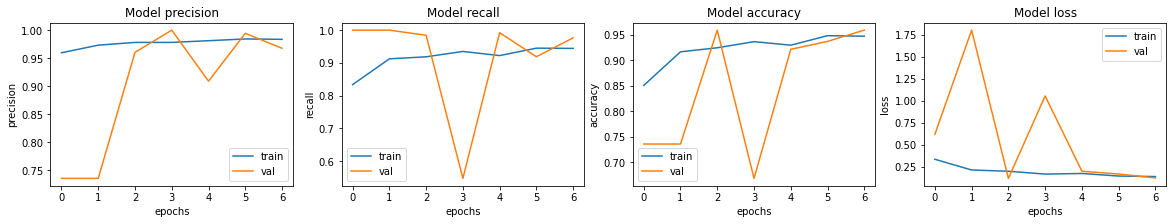

In [ ]:
plot(model5[0])

#### ▶ 모델 6:


- BATCH_SIZE = 8

- Dropout 만 진행

- ~~BN 제거~~

In [ ]:
model6 = modify_params(BATCH_SIZE = 8)

Epoch 1/25
523/523 [==============================] - 194s 356ms/step - loss: 0.3670 - accuracy: 0.8346 - precision: 0.9569 - recall: 0.8143 - val_loss: 0.8417 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
523/523 [==============================] - 151s 289ms/step - loss: 0.2912 - accuracy: 0.8786 - precision: 0.9680 - recall: 0.8653 - val_loss: 0.2478 - val_accuracy: 0.9058 - val_precision: 0.9970 - val_recall: 0.8748
Epoch 3/25
523/523 [==============================] - 151s 288ms/step - loss: 0.2691 - accuracy: 0.8865 - precision: 0.9674 - recall: 0.8769 - val_loss: 1.8525 - val_accuracy: 0.4577 - val_precision: 1.0000 - val_recall: 0.2637
Epoch 4/25
523/523 [==============================] - 150s 287ms/step - loss: 0.2437 - accuracy: 0.8965 - precision: 0.9705 - recall: 0.8878 - val_loss: 0.1868 - val_accuracy: 0.9375 - val_precision: 0.9986 - val_recall: 0.9164
Epoch 5/25
523/523 [==============================] - 150s 286ms/step - loss: 0.2322 - a

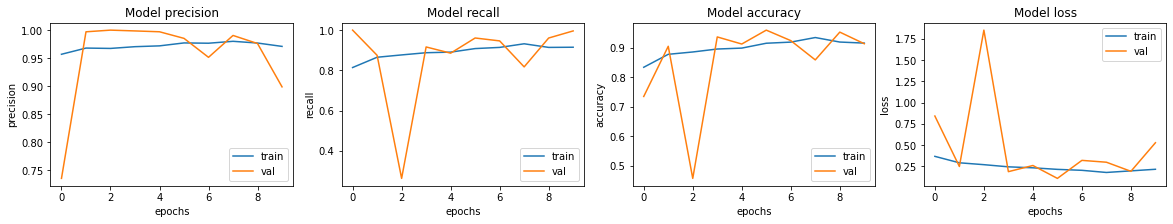

In [ ]:
plot(model6[0])

#### ▶ 모델 7:

- BATCH_SIZE = 8

- class_weight = {0:1,1:1}
  - class weight이 없는 경우

In [ ]:
model7 = modify_params(BATCH_SIZE = 8,class_weight = {0:1,1:1})

Epoch 1/25
523/523 [==============================] - 158s 288ms/step - loss: 0.3468 - accuracy: 0.8599 - precision: 0.9174 - recall: 0.8920 - val_loss: 1.4094 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
523/523 [==============================] - 151s 289ms/step - loss: 0.2251 - accuracy: 0.9082 - precision: 0.9380 - recall: 0.9386 - val_loss: 0.1066 - val_accuracy: 0.9606 - val_precision: 0.9814 - val_recall: 0.9648
Epoch 3/25
523/523 [==============================] - 150s 288ms/step - loss: 0.2083 - accuracy: 0.9204 - precision: 0.9444 - recall: 0.9489 - val_loss: 0.1357 - val_accuracy: 0.9404 - val_precision: 0.9444 - val_recall: 0.9765
Epoch 4/25
523/523 [==============================] - 150s 286ms/step - loss: 0.1861 - accuracy: 0.9273 - precision: 0.9468 - recall: 0.9559 - val_loss: 3.0397 - val_accuracy: 0.7356 - val_precision: 0.7353 - val_recall: 1.0000
Epoch 5/25
523/523 [==============================] - 149s 285ms/step - loss: 0.1794 - a

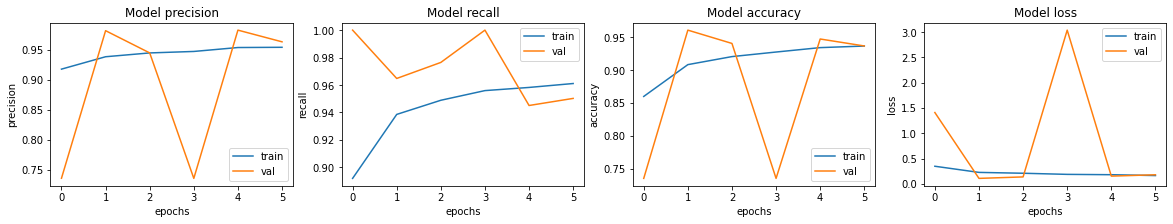

In [ ]:
plot(model7[0])

#### ▶ 모델 8:

- BATCH_SIZE = 8

- class_weight = {0:1,1:1}
  - class weight이 없는 경우

- Conv2D = 8

- Dropout = 0.1

In [ ]:
model8 = modify_params(BATCH_SIZE = 8,class_weight = {0:1,1:1})

Epoch 1/25
523/523 [==============================] - 160s 293ms/step - loss: 0.3484 - accuracy: 0.8583 - precision: 0.9248 - recall: 0.8811 - val_loss: 0.8221 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
523/523 [==============================] - 149s 285ms/step - loss: 0.2415 - accuracy: 0.9061 - precision: 0.9342 - recall: 0.9399 - val_loss: 1.8131 - val_accuracy: 0.3183 - val_precision: 1.0000 - val_recall: 0.0744
Epoch 3/25
523/523 [==============================] - 149s 286ms/step - loss: 0.2128 - accuracy: 0.9211 - precision: 0.9447 - recall: 0.9495 - val_loss: 0.3052 - val_accuracy: 0.8269 - val_precision: 0.8153 - val_recall: 0.9896
Epoch 4/25
523/523 [==============================] - 148s 283ms/step - loss: 0.1774 - accuracy: 0.9300 - precision: 0.9496 - recall: 0.9566 - val_loss: 0.1202 - val_accuracy: 0.9558 - val_precision: 0.9523 - val_recall: 0.9896
Epoch 5/25
523/523 [==============================] - 137s 262ms/step - loss: 0.1677 - a

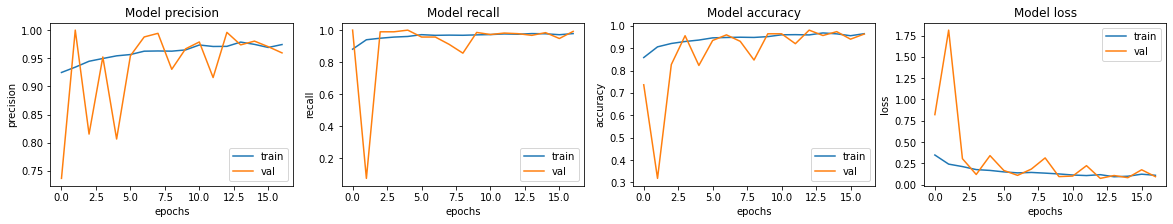

In [ ]:
plot(model8[0])

#### 결과

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

result_dict = {
    "Model": ['standard', 'Up-model_1', 'Up-model_2', 'Up-model_3', 'Up-model_4', 'Up-model_5', 'Up-model_6', 'Up-model_7', 'Up-model_8'],
    "Loss": [1.0209, 1.3006, 2.3284, 0.5364, 0.4824, 0.7514, 1.6261, 0.4008, 1.4078], 
    "Accuracy": [0.8029, 0.7067, 0.625, 0.8205, 0.8029, 0.7756, 0.7356, 0.8670, 0.7356], 
    "Precision": [0.770, 0.6832, 0.625, 0.7932, 0.9211, 0.7385, 0.7034, 0.8550, 0.7034],
    "Recall": [0.9770, 0.990, 1.0, 0.9641, 0.7487, 0.9923, 0.9974, 0.9487, 0.9974]
}
plt.style.use('ggplot')
result_df = pd.DataFrame(result_dict, index=['standard', 'Up-model_1', 'Up-model_2', 'Up-model_3', 'Up-model_4', 'Up-model_5', 'Up-model_6', 'Up-model_7', 'Up-model_8'])
result_df.plot.bar(figsize=(15, 10))
plt.xlabel('Model')
plt.ylabel('performance')
plt.xticks(rotation=45)
result_df

### 9. 회고 🍀

**▶ 성능 개선 모델**

1. BATCH_SIZE = 16, epoches = 25, optimizer = 'adam', rugularizer = 0, class_weight = class_weight, augment = True

2. BATCH_SIZE = 32,  이하 동일

3. BATCH_SIZE = 8, 이하 동일

4. BATCH_SIZE = 8, BN 만 진행, Dropout 제거, 이하 동일

5. BATCH_SIZE = 16, Dropout 만 진행, BN 제거, 이하 동일

6. BATCH_SIZE = 8, Dropout 만 진행, BN 제거, 이하 동일

7. BATCH_SIZE = 8, class_weight = {0:1,1:1} / class weight이 없는 경우

8. BATCH_SIZE = 8, class_weight = {0:1,1:1} / class weight이 없는 경우, Conv2D = 8, Dropout = 0.1

- 모델에 다양한 parameters 변화로 성능에 미치는 영향을 확인해보았다.


- 최고의 성능을 보여준 모델은 **Up-model_7** 으로 Loss: 0.4, Accuracy: 0.876 으로 standard 보다 5프로 높게 나왔다.

|index|Model|Loss|Accuracy|Precision|Recall|
|---|---|---|---|---|---|
|standard|standard|1\.0209|0\.8029|0\.77|0\.977|
|Up-model\_1|Up-model\_1|1\.3006|0\.7067|0\.6832|0\.99|
|Up-model\_2|Up-model\_2|2\.3284|0\.625|0\.625|1\.0|
|Up-model\_3|Up-model\_3|0\.5364|0\.8205|0\.7932|0\.9641|
|Up-model\_4|Up-model\_4|0\.4824|0\.8029|0\.9211|0\.7487|
|Up-model\_5|Up-model\_5|0\.7514|0\.7756|0\.7385|0\.9923|
|Up-model\_6|Up-model\_6|1\.6261|0\.7356|0\.7034|0\.9974|
|Up-model\_7|Up-model\_7|0\.4008|0\.867|0\.855|0\.9487|
|Up-model\_8|Up-model\_8|1\.4078|0\.7356|0\.7034|0\.9974|

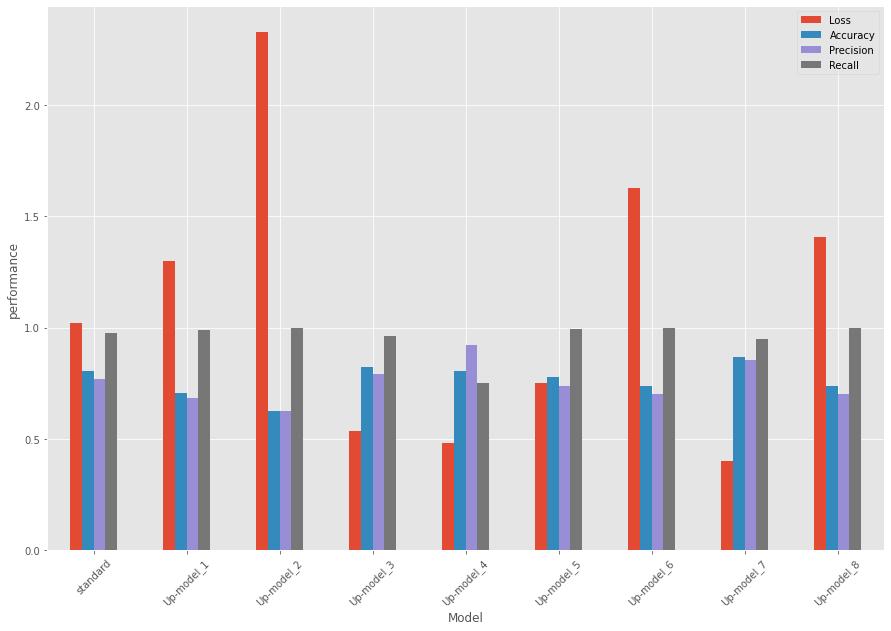

**▶ Up-model_8 추가 학습**

- **class weight** 이 없는 경우가 성능치가 높게 나와 **Up-model_8** 에서 같은 조건에서 `Dropout=0.1`, `Conv2D=8` 만 변경하여 추가 학습을 진행하였다.

- **Up-model_8**의 결과는 Loss: 1.4078, Accuracy: 0.7356 으로 낮게 나오는데 특이점은 Epoch 17까지는 loss: 0.1104, Accuracy: 0.9649 으로 높게 나오다 마지막에 급격하게 하락한 것이 보였다.

- `earlystopping` 으로 개선되지 않을 시 Epoch을 중단을 걸어놔서 오버피팅은 회피 할 것 같았는데... 이유는 모르겠다.





이번 프로젝트를 진행하면서 인공지능으로 인간에서 조금이나마 영향력있는 개발을 하지 않았나 싶다.   

85.5%의 확률로 양성, 음성을 판단하는면에서 정확도가 많이 떨어지겠지만, 1차 진단용으로는 적합하지 않을까 싶다.

나중에 시간을 더 투자해서 정확도를 올리는 작업을 하면 좋을 것 같다. 이상 끝!! 👽